# Predicting Loan Delinquency

Financial institutions in the consumer credit business offer loans with personalized interest rates. Many of these customers may not have a long enough credit history for financial institutions to rely only on credit scores to offer loans. The ability to estimate the probablity of a loan being charged-off would significantly reduce the credit risk associated with these loans.

This project aims to predict loans that could go bad, even before they are sanctioned. 

## Importing dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Set max columns and rows for displaying large dataframes
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
plt.rcParams["figure.figsize"] = (16, 9)

## Preparing the dataset

The primary dataset for training and validating loan default predictions has been obtained from [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data).

In [2]:
data = pd.read_csv('loan.csv', nrows=1000000, low_memory=False)

In [3]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1.0,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,16901,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000,1.0,11.0,2.0,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0.0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,1208,321915,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800,2.0,15.0,2.0,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0.0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,M

In [4]:
data.shape

(1000000, 145)

### Target

Let us first explore the target column - loan_status.

In [5]:
target='loan_status'

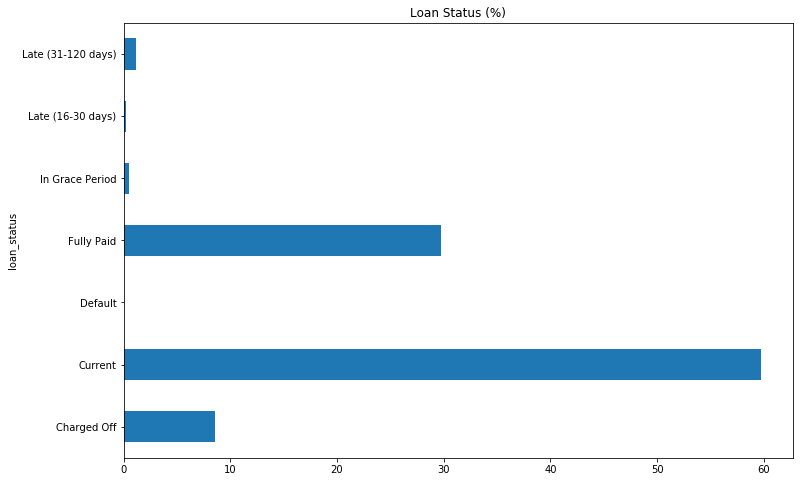

In [6]:
plt.rcParams["figure.figsize"] = (12, 8)
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

Since 60% of loans are current, we don't know if these loans will end up being good or bad. So, our machine learning models are unlikely to predict accurate status of loan delinquency. 

Now, let's transform the different loan_status categories to either 'good' or 'bad'.

In [7]:
status = {
    'Charged Off': 'bad',
    'Current': 'good',
    'Default': 'bad',
    'Does not meet the credit policy. Status:Charged Off': 'bad',
    'Does not meet the credit policy. Status:Fully Paid': 'good',
    'Fully Paid': 'good',
    'In Grace Period': 'bad',
    'Late (16-30 days)': 'bad',
    'Late (31-120 days)': 'bad'
}
data['loan_status'] = data['loan_status'].map(lambda x: status[x])

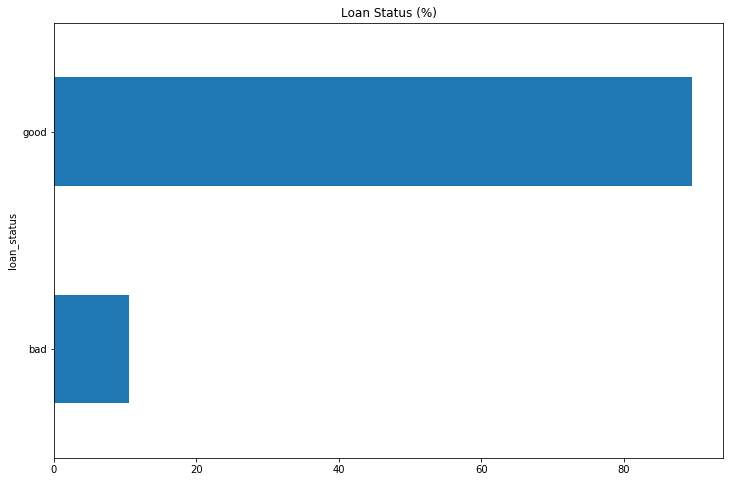

In [8]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

### Summary

In [9]:
data.groupby(['loan_status'])['loan_amnt'].count()

loan_status
bad     105209
good    894791
Name: loan_amnt, dtype: int64

In [10]:
data['loan_amnt'].sum()

15394886100

In [11]:
data['total_pymnt'].sum()

9257308149.518654

### Feature Transformation

The 'term' feature has the string 'months' appended to its numerical values. This needs to be removed. 

In [12]:
data['term'] = data['term'].dropna().map(lambda term: int(term.replace("months", "").strip()))

Some features have dates. So, let's retain only the year from the dates. 

In [13]:
columns=['issue_d', 'earliest_cr_line']
for col in np.intersect1d(columns, data.columns):
    data[col] = data[col].dropna().map(lambda date: int(date.split('-')[1].strip()))

### Finally

In [14]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,2001,1.0,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,16901,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000,1.0,11.0,2.0,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,1987,0.0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,1208,321915,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800,2.0,15.0,2.0,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,2011,0.0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,11

In [15]:
data.shape

(1000000, 145)

## Visualizing the data

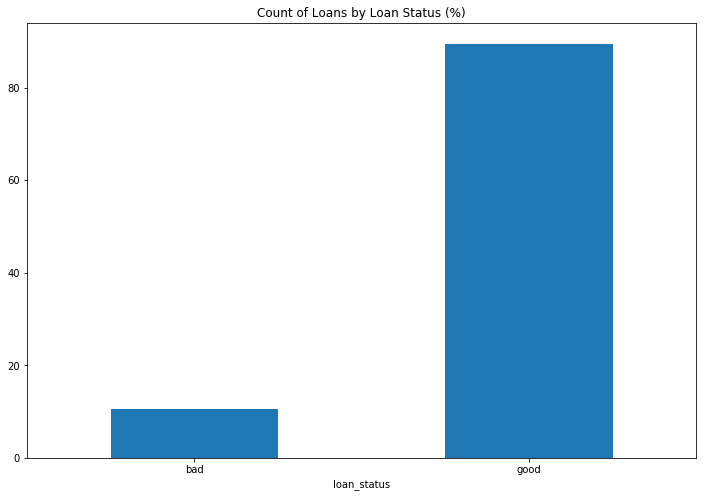

In [16]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Loan Status (%)', rot=0)
plt.show()

About 15% (of 1 Million loans) are bad. 

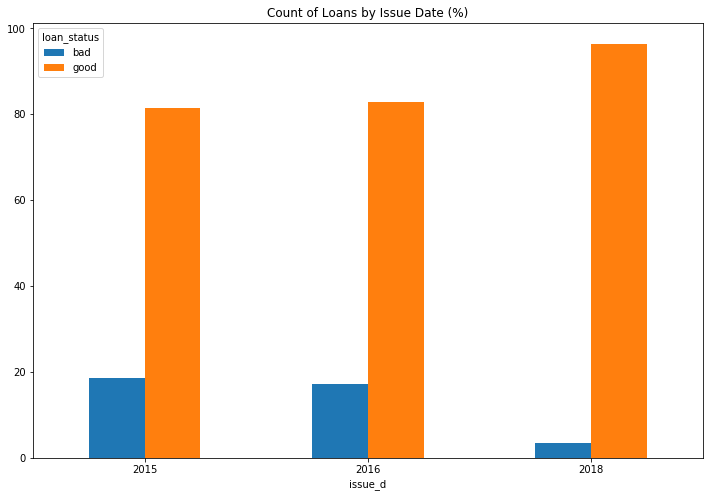

In [17]:
df = 100 * data.groupby(['loan_status', 'issue_d'])['loan_amnt'].count() / data.groupby(['issue_d'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Issue Date (%)', rot=0)
plt.show()

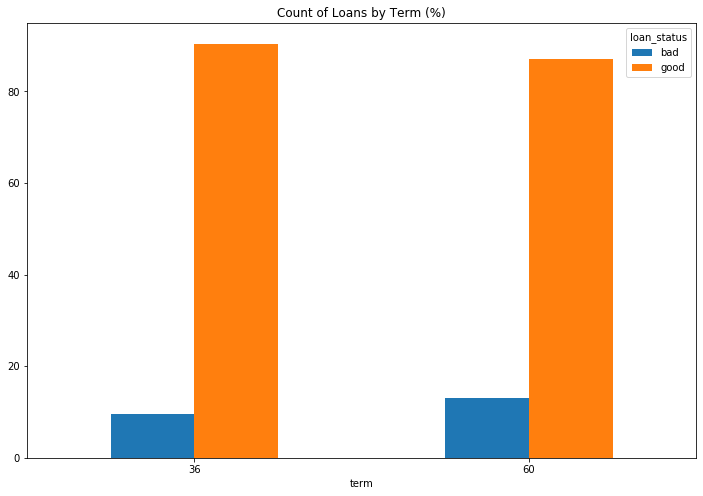

In [18]:
df = 100 * data.groupby(['loan_status', 'term'])['loan_amnt'].count() / data.groupby(['term'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Term (%)', rot=0)
plt.show()

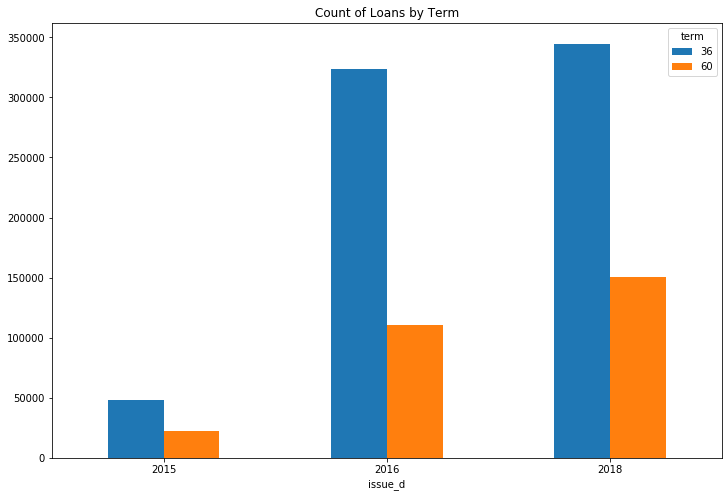

In [19]:
df = data.groupby(['term', 'issue_d'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Term', rot=0)
plt.show()

Since all loans are recent, most loans are Current.

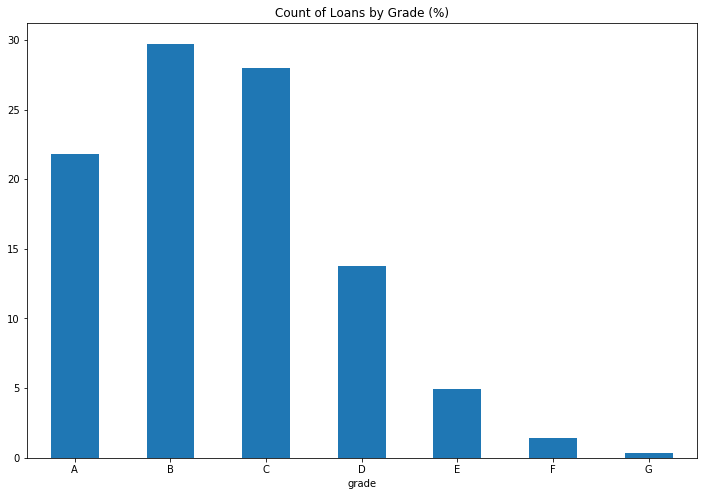

In [20]:
df = 100 * data.groupby(['grade'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

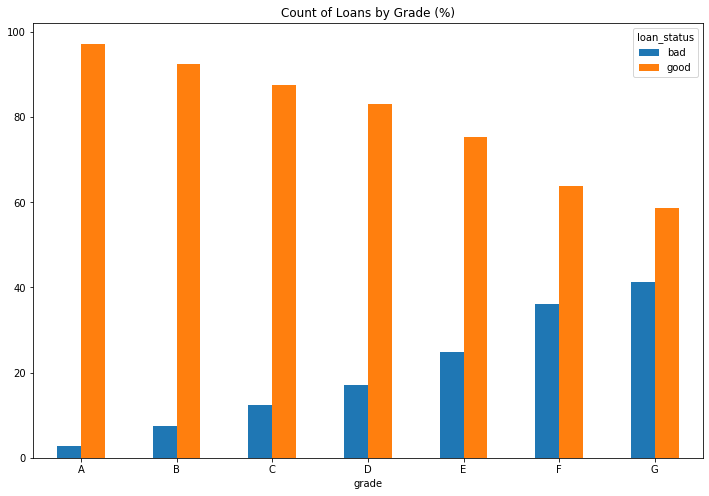

In [21]:
df = 100 * data.groupby(['loan_status', 'grade'])['loan_amnt'].count() / data.groupby(['grade'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

More loans are offered to grades with lower risk. 

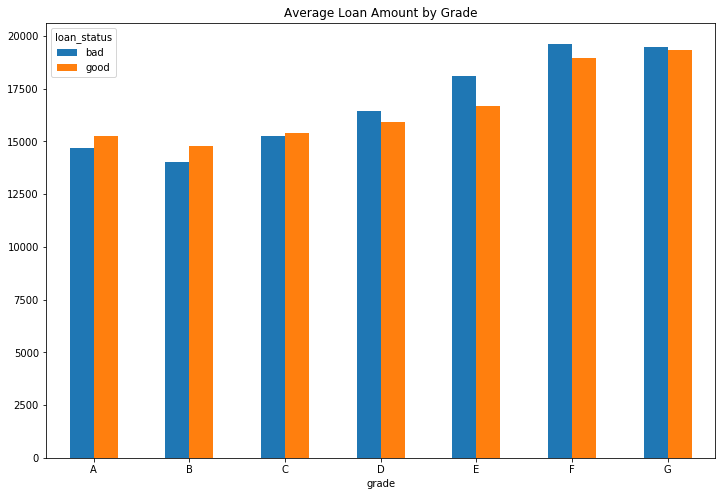

In [22]:
df = data.groupby(['loan_status', 'grade'])['loan_amnt'].mean()
df.unstack(level=0).plot.bar(title='Average Loan Amount by Grade', rot=0)
plt.show()

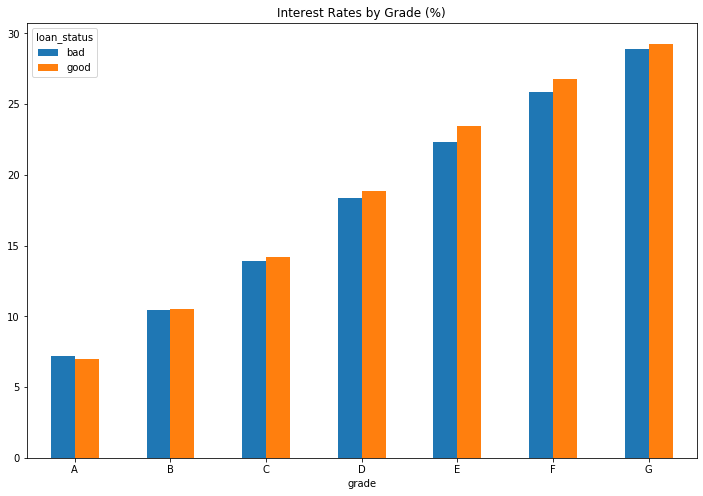

In [23]:
df = data.groupby(['loan_status', 'grade'])['int_rate'].mean()
df.unstack(level=0).plot.bar(title='Interest Rates by Grade (%)', rot=0)
plt.show()

Grades with higher risk are charged with higher interest rates. 

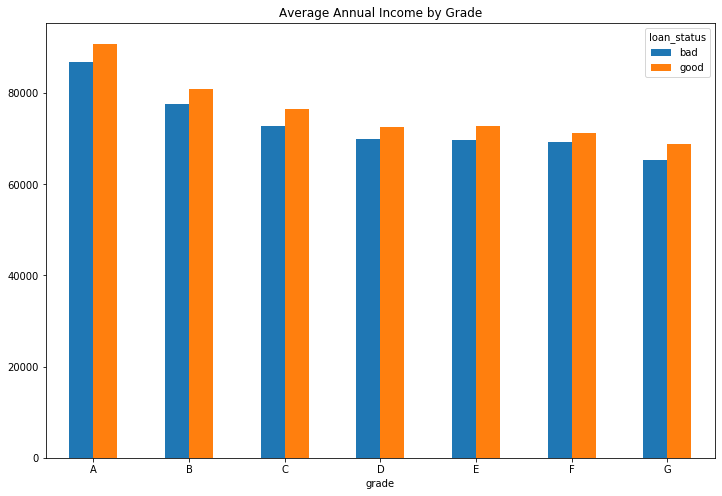

In [24]:
df = data.groupby(['loan_status', 'grade'])['annual_inc'].mean()
df.unstack(level=0).plot.bar(title='Average Annual Income by Grade', rot=0)
plt.show()

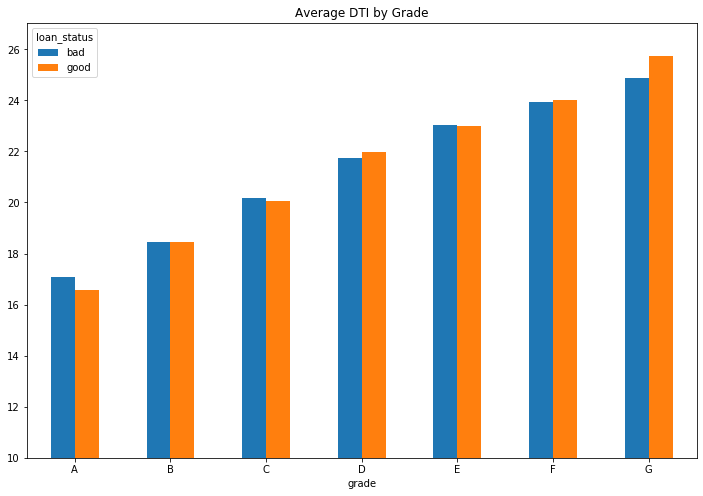

In [25]:
df = data.groupby(['loan_status', 'grade'])['dti'].mean()
df.unstack(level=0).plot.bar(title='Average DTI by Grade', rot=0, ylim=10)
plt.show()

Higher the debt-to-income ratio, higher the risk of loan going bad. 

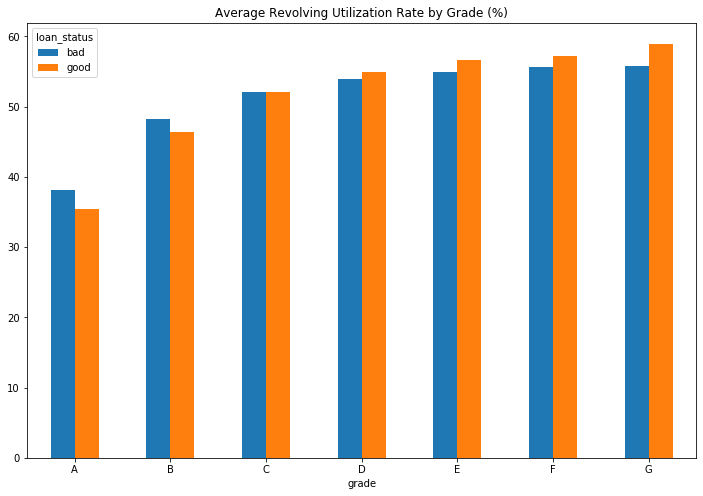

In [26]:
df = data.groupby(['loan_status', 'grade'])['revol_util'].mean()
df.unstack(level=0).plot.bar(title='Average Revolving Utilization Rate by Grade (%)', rot=0)
plt.show()

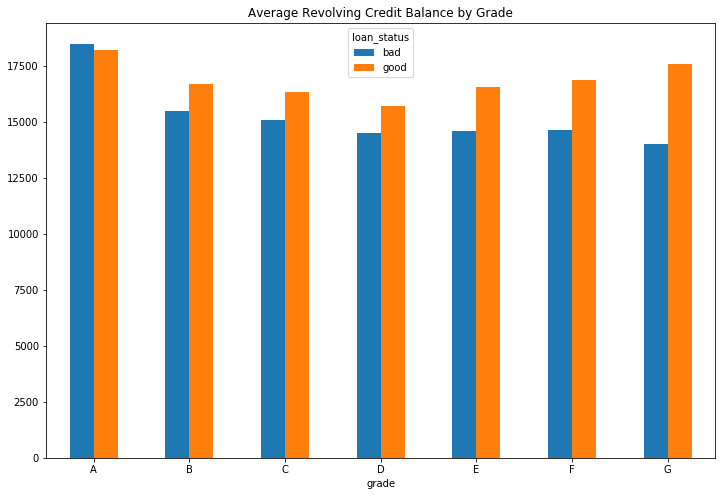

In [27]:
df = data.groupby(['loan_status', 'grade'])['revol_bal'].mean()
df.unstack(level=0).plot.bar(title='Average Revolving Credit Balance by Grade', rot=0)
plt.show()

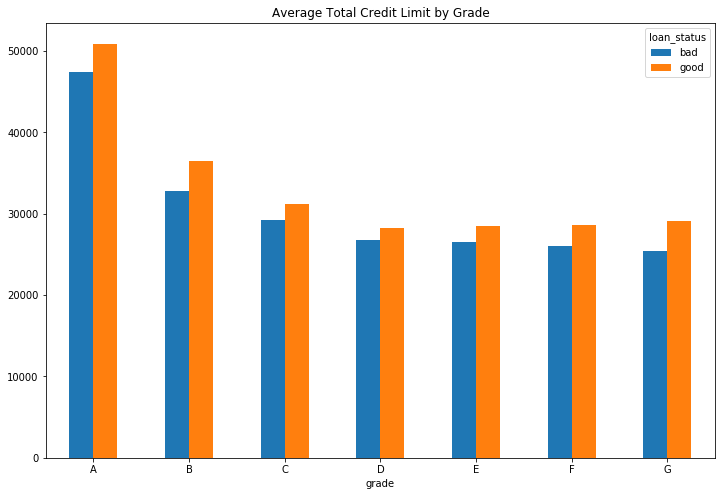

In [28]:
df = data.groupby(['loan_status', 'grade'])['total_rev_hi_lim'].mean()
df.unstack(level=0).plot.bar(title='Average Total Credit Limit by Grade', rot=0)
plt.show()

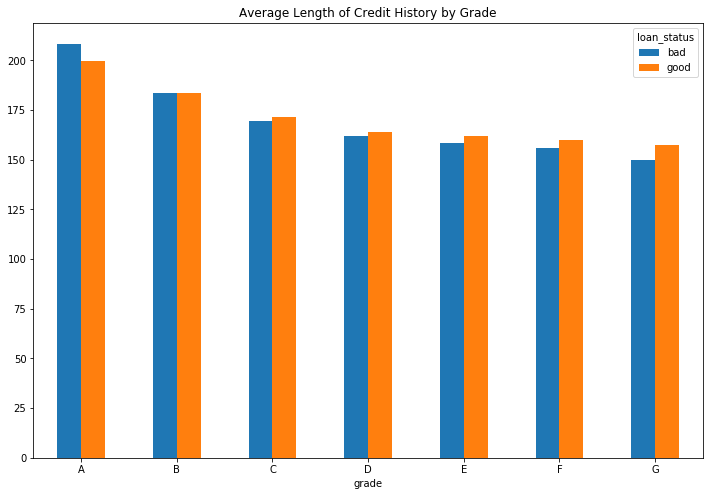

In [29]:
df = data.groupby(['loan_status', 'grade'])['mo_sin_old_rev_tl_op'].mean()
df.unstack(level=0).plot.bar(title='Average Length of Credit History by Grade', rot=0)
plt.show()

Groups A to G have increasing order of risk, because of higher debt-to-income ratio, lower total credit limit and shorter credit history.

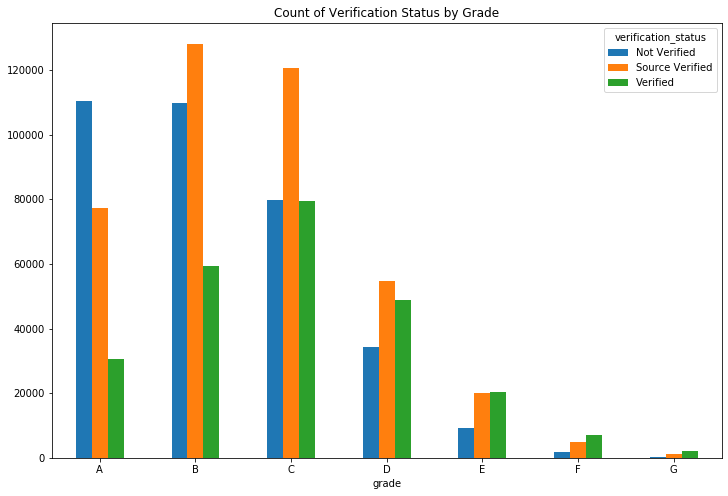

In [30]:
df = data.groupby(['verification_status', 'grade'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Verification Status by Grade', rot=0)
plt.show()

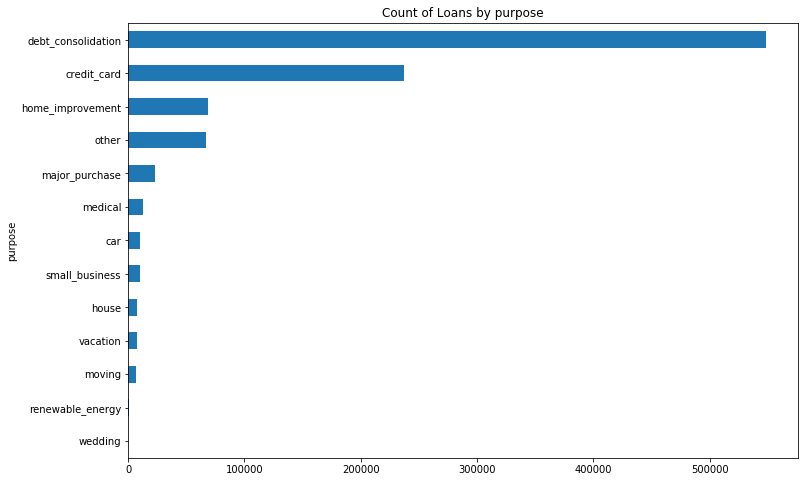

In [31]:
df = data.groupby(['purpose'])['loan_amnt'].count()
df.sort_values().plot.barh(title='Count of Loans by purpose', rot=0)
plt.show()

## Preprocessing the data

### Handling missing values

Some columns have critical data which cannot be assumed or inferred. If rows are found to have missing values in such columns, they need to be ignored.

In [32]:
columns = ['loan_status', 'loan_amnt', 'dti', 'annual_inc', 'term']
data.dropna(subset=np.intersect1d(columns, data.columns), inplace=True)

Some features have too many missing values and cannot be imputed efficiently. So, let's drop them. 

In [33]:
data.dropna(axis='columns', thresh=data.shape[0]*0.99, inplace=True)

Missing values will be imputed. 

### Encoding Categorical Features

Non-numerical or Categorical features need to be encoded. 

In [34]:
data.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                            int64
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                         int64
loan_status                    object
pymnt_plan                     object
purpose                        object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line                int64
inq_last_6mths                float64
open_acc                        int64
pub_rec                         int64
revol_bal                       int64
revol_util                    float64
total_acc                       int64
initial_list

In [35]:
from sklearn.preprocessing import LabelEncoder

# for each column with type 'object'
for col in data.select_dtypes(exclude=['int64', 'float64']).columns:
    # Fill missing values in column with empty string
    data[col].fillna('', inplace=True)

    # Encode categorical feature
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

Using LabelEncoder instead of OneHotEncoder, because of the following error:

```
ValueError: Expected 2D array, got 1D array instead:
array=['C' 'D' 'D' ... 'B' 'E' 'B'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
```

### Feature Reduction

Some features are not available to us at the time of sanctioning loans. These features must be removed from the dataset. 

In [36]:
columns = [
    'id','member_id','url','funded_amnt','funded_amnt_inv','total_acc','out_prncp','out_prncp_inv','pymnt_plan',
    'open_acc','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 
    'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'acc_open_past_24mths', 'bc_open_to_buy', 
    'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc', 'percent_bc_gt_75', 
    'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'hardship_flag', 'debt_settlement_flag', 
    'total_pymnt', 'next_pymnt_d', 'tot_coll_amt', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 
    'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 
    'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 
    'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 
    'settlement_percentage', 'settlement_term','issue_d','mo_sin_old_rev_tl_op','mo_sin_rec_rev_tl_op','policy_code', 'num_tl_30dpd',
]
data.drop(columns=np.intersect1d(columns, data.columns), inplace=True)

One feature from each pair of highly correlated features needs to be dropped. 

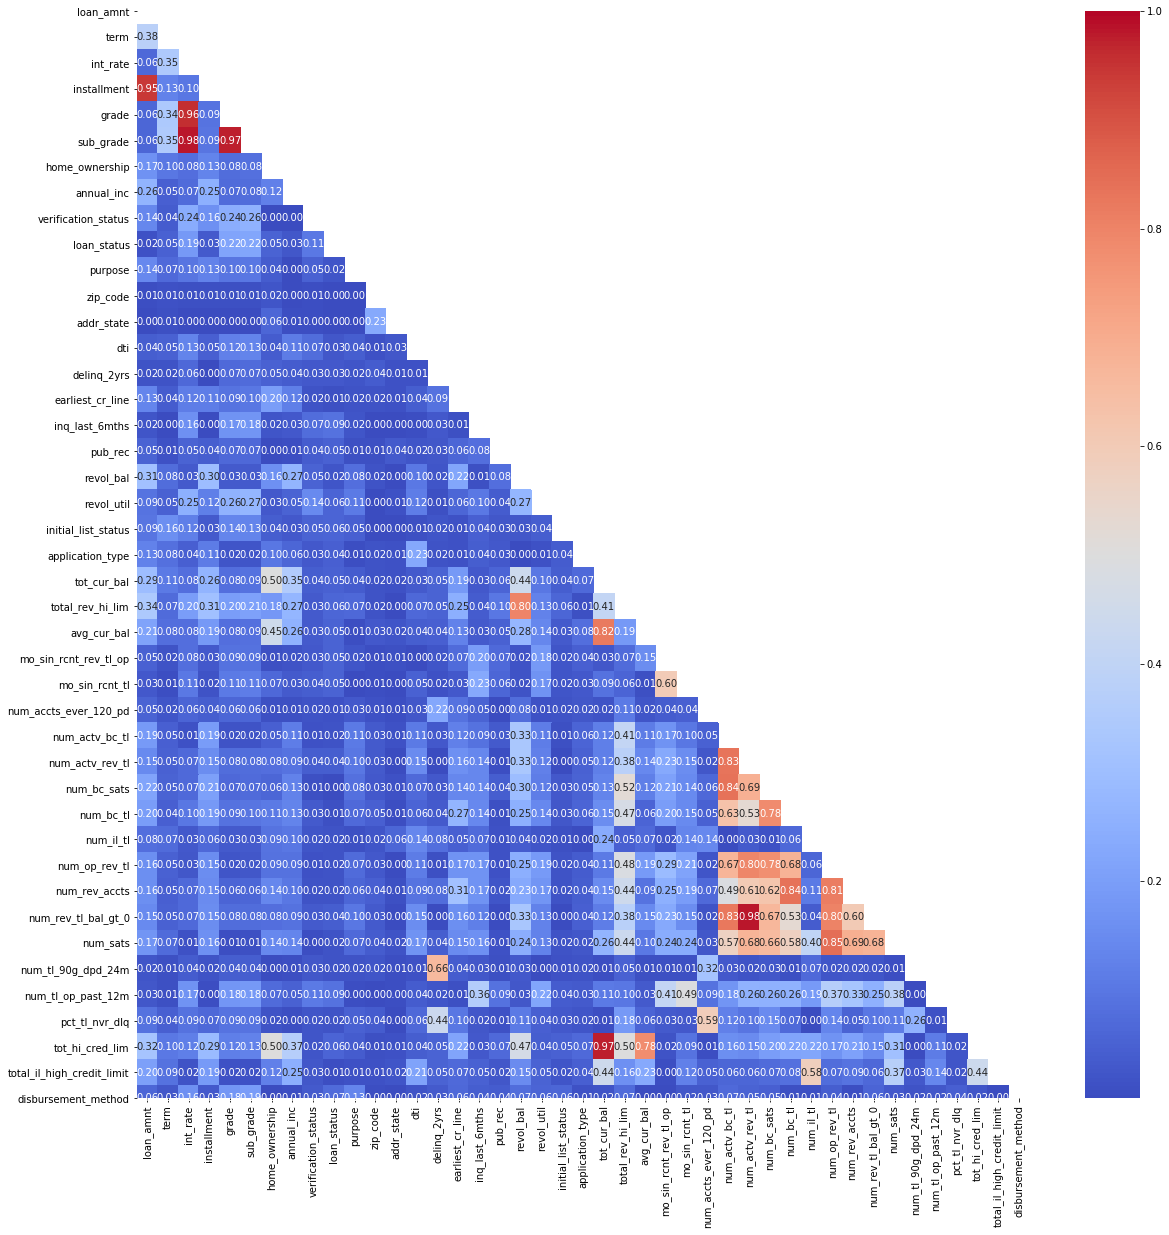

In [37]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 20)

corr = data.corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

In [38]:
columns = [
    'int_rate','sub_grade','installment','title','all_util','avg_cur_bal','tot_cur_bal','total_bal_il','open_il_12m',
    'open_il_24m','open_rv_12m','open_rv_24m','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
    'num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_90g_dpd_24m',
    'num_tl_op_past_12m','revol_bal','zip_code','addr_state','application_type','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
    'total_rev_hi_lim','total_il_high_credit_limit','purpose','initial_list_status','disbursement_method'
]
data.drop(columns=np.intersect1d(columns, data.columns), inplace=True)

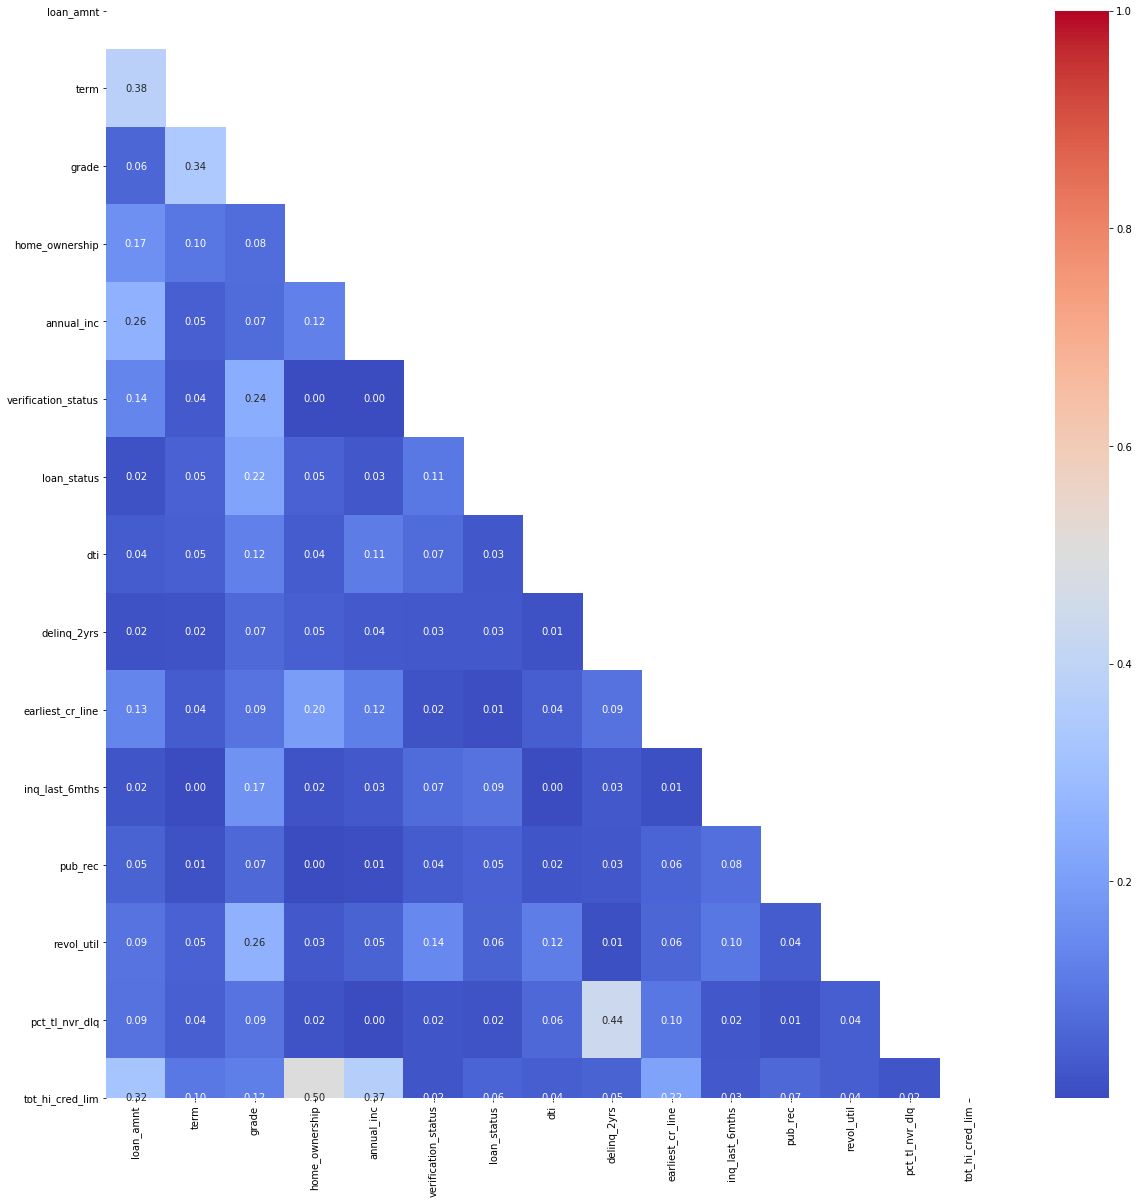

In [39]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 20)

corr = data.corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

### Finally

After all pre-processing steps, our final dataset looks like this.

In [40]:
data.head(3)

,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,pub_rec,revol_util,pct_tl_nvr_dlq,tot_hi_cred_lim
0,2500,36,2,3,55000.0,0,1,18.24,0,2001,1.0,1,10.3,100.0,60124
1,30000,60,3,1,90000.0,1,1,26.52,0,1987,0.0,1,24.2,95.0,372872
2,5000,36,3,1,59280.0,1,1,10.51,0,2011,0.0,0,19.1,100.0,136927


In [41]:
data.shape

(998803, 15)

## Modeling

Let us split our dataset for training and testing models. 

In [42]:
from sklearn.model_selection import train_test_split

X = data.drop(target, axis='columns', inplace=False)
y = data[target]

# default split is 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=(data[target]+1)*(data['grade']+1)*(data['term']), random_state=123)

### Feature Selection

Some features are more important than others. Features with low importance add noise, and must be removed. 

A trained RandomForestClassifier can be used to identify importance of features. 

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# create a Random Forest Classifier pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('scaler', MinMaxScaler()), # scale values to range [0,1]
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1))
])
rf_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                             

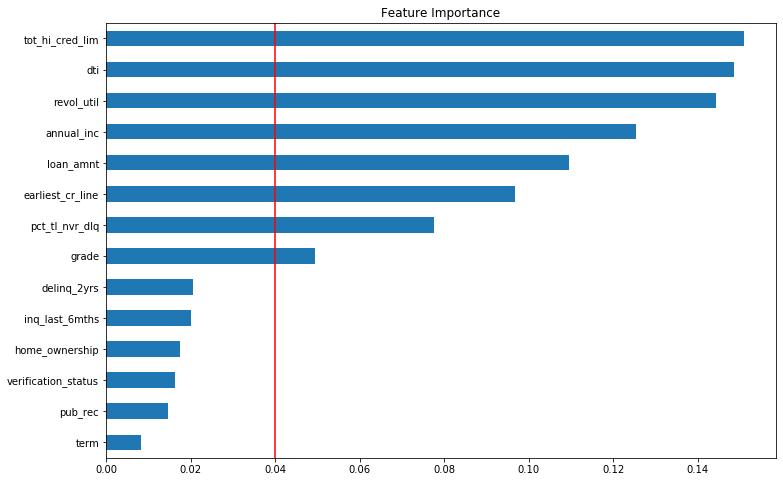

In [44]:
# Plot the name and gini importance of each feature
plt.rcParams["figure.figsize"] = (12, 8)
imp_features=pd.Series(rf_pipeline.named_steps['classifier'].feature_importances_, index=X.columns)
imp_features.sort_values().plot(title='Feature Importance', kind='barh')

# draw red verticle line at threshold
plt.axvline(x=0.04, c='r')

In [45]:
#show important features
#important_features = list(imp_features[imp_features > 0.03].keys())
#important_features = list(imp_features.sort_values(ascending=False).head(10).keys())
important_features = list(imp_features.sort_values(ascending=False)[imp_features > 0.04].keys())
X[important_features].head()

,tot_hi_cred_lim,dti,revol_util,annual_inc,loan_amnt,earliest_cr_line,pct_tl_nvr_dlq,grade
0,60124,18.24,10.3,55000.0,2500,2001,100.0,2
1,372872,26.52,24.2,90000.0,30000,1987,95.0,3
2,136927,10.51,19.1,59280.0,5000,2011,100.0,3
3,385183,16.74,78.1,92000.0,4000,2006,100.0,3
4,157548,26.35,3.6,57250.0,30000,2000,92.3,2


Let us verify that the selected features have low correlation. 

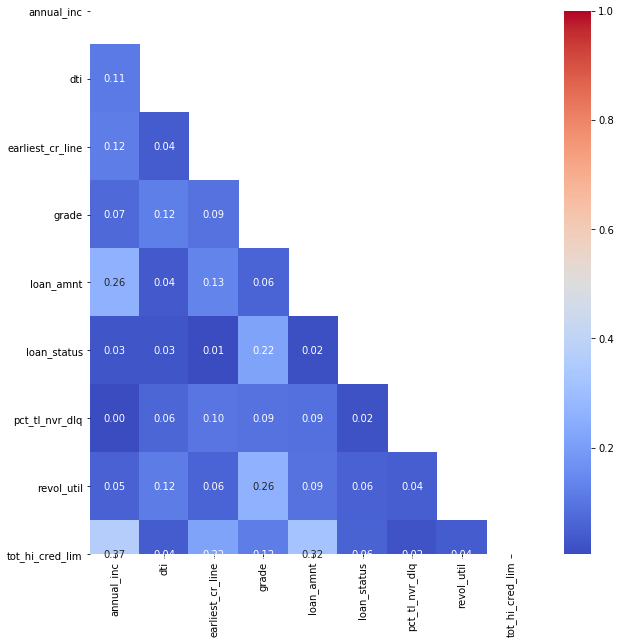

In [46]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 10)

corr = data[np.union1d(important_features, target)].corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

Let us now build a SelectFromModel step to ignore features with low importance. 

In [47]:
from sklearn.feature_selection import SelectFromModel
#select_important_features = SelectFromModel(rf_pipeline.named_steps['classifier'], max_features=10, threshold=-np.inf)
select_important_features = SelectFromModel(rf_pipeline.named_steps['classifier'], threshold=0.04)

### Logistic Regression

Let us build, evaluate and tune a LogisticRegression model. 

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# for tuning hyper parameters
param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'penalty': ['none', 'l2']
    },
    {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1']
    }
]

lr_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('selector', select_important_features), # select only the important features
    ('scaler', MinMaxScaler()), # scale values to range [0,1]
    ('classifier',GridSearchCV(LogisticRegression(random_state=123),param_grid=param_grid,cv=3,refit=True,n_jobs=-1))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                               

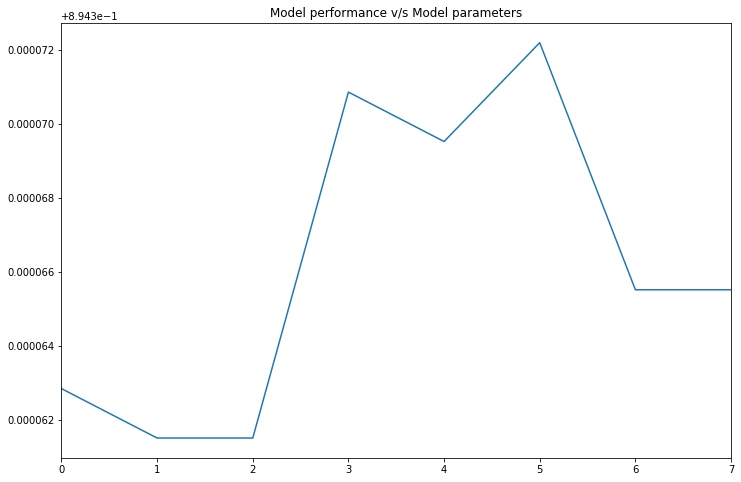

In [49]:
# plot model performance for each parameter set
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(lr_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [50]:
lr_pipeline.named_steps['classifier'].best_score_

0.8943721949747832

In [51]:
lr_pipeline.named_steps['classifier'].best_params_

{'penalty': 'l2', 'solver': 'sag'}

In [52]:
# Calculate area under the ROC curve score

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, lr_pipeline.predict(X_test))

0.5035733185499055

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

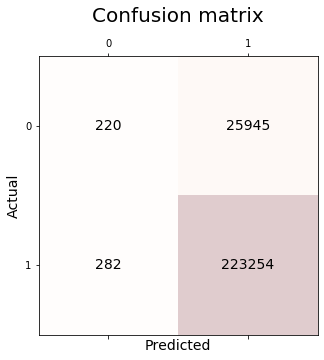

In [53]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

predictions = lr_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

### Gradient Boosting Classifier

Now, let us build, evaluate and tune a GradientBoostingClassifier. 

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

# for tuning hyper parameters 
param_grid = {
    'n_estimators': [10, 100],
    'max_features': [None, 'sqrt'],
    'learning_rate': [0.1, 0.5],
    #'max_leaf_nodes': [2, 8],
    #'min_samples_split': [0.1, 0.3]
}

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('selector', select_important_features), # select only the important features
    ('scaler', MinMaxScaler()), # scale values to range [0,1]
    ('classifier', GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=3, refit=True, n_jobs=-1))
])
gb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                               

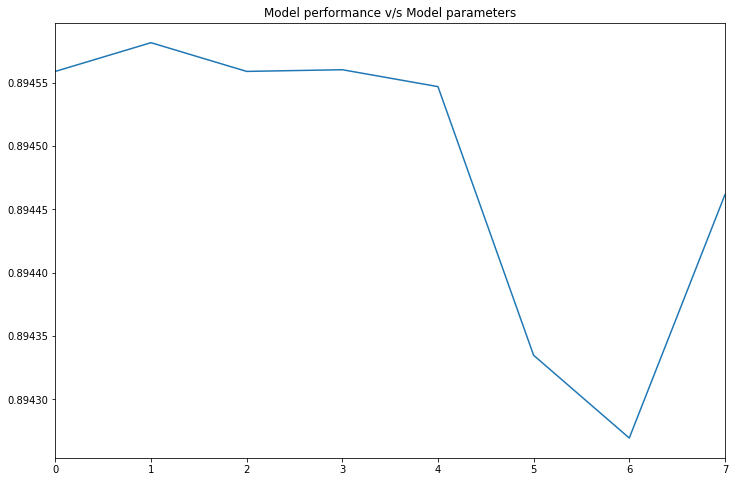

In [55]:
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(gb_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [56]:
gb_pipeline.named_steps['classifier'].best_score_

0.8945817792503558

In [57]:
gb_pipeline.named_steps['classifier'].best_params_

{'learning_rate': 0.1, 'max_features': None, 'n_estimators': 100}

In [58]:
# Calculate area under the ROC curve score
roc_auc_score(y_test, gb_pipeline.predict(X_test))

0.5003327870726677

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

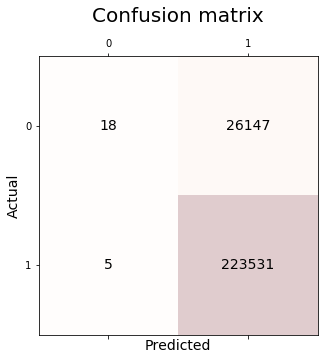

In [59]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

predictions = gb_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

### Neural Networks

Now, let us try to build, evaluate and tune a Neural Network. 

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# This function is a template for creating neural networks
def build_classifier(optimizer='adam', layers=2, add_dropout_layers=False, dropout_rate=0.1):
    # first step: create a Sequential object, as a sequence of layers. B/C NN is a sequence of layers.
    classifier = Sequential()
    
    for i in range(layers):
        # add the hidden layer
        classifier.add(Dense(units=5,kernel_initializer='glorot_uniform',activation = 'relu'))
        
        # add dropout layer
        if add_dropout_layers:
            classifier.add(Dropout(rate=dropout_rate))  #often start with 0.1, not solved go up
    
    # add the output layer
    classifier.add(Dense(units=1,kernel_initializer='glorot_uniform',activation = 'sigmoid'))
    
    # compiling the NN
    classifier.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return classifier


# a neural network
classifier = KerasClassifier(build_fn=build_classifier, batch_size=10, nb_epoch=3)

# for tuning hyper parameters 
param_grid = {
    'batch_size':[10, 100], 
    'nb_epoch':[1, 10],
    #'optimizer':['adam','rmsprop'],
    'layers': [0, 1, 2],
    #'add_dropout_layers': [False, True]
}

nn_pipeline = Pipeline([
    ('imputer', SimpleImputer()),  # fill missing values with mean of column
    ('selector', select_important_features),  # select only the important features
    ('scaler', MinMaxScaler()),  # scale values to range [0,1]
    ('classifier', GridSearchCV(classifier, param_grid=param_grid, cv=3, scoring='accuracy', refit=True, n_jobs=-1))  
])
nn_pipeline.fit(X_train, y_train)

Using TensorFlow backend.


Epoch 1/1
749102/749102 [==============================] - 53s 70us/step - loss: 0.3170 - accuracy: 0.8931


Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                ('scaler', MinMaxScaler(copy=Tr

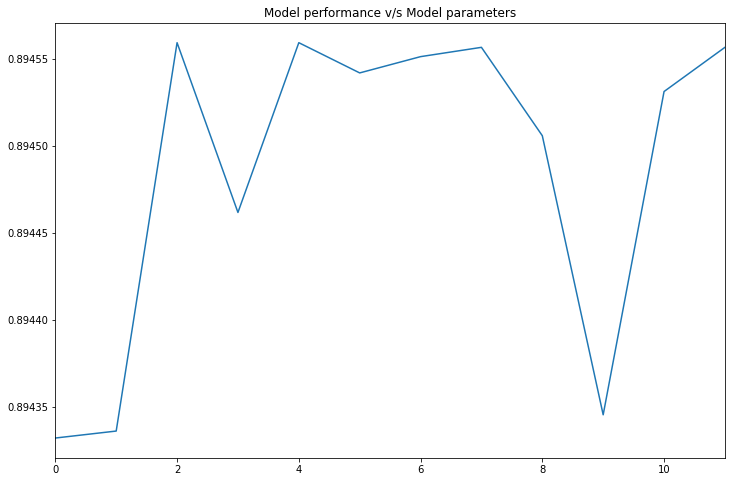

In [61]:
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(nn_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [62]:
nn_pipeline.named_steps['classifier'].best_score_

0.8945590854115995

In [63]:
nn_pipeline.named_steps['classifier'].best_params_

{'batch_size': 10, 'layers': 1, 'nb_epoch': 1}

In [64]:
roc_auc_score(y_test, nn_pipeline.predict(X_test))

0.5046468499803782

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

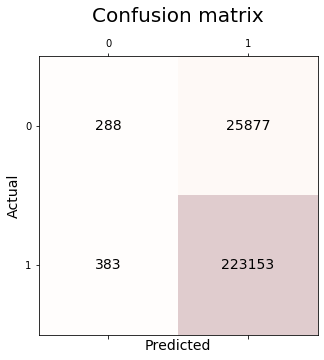

In [65]:
# Confusion Matrix
predictions = nn_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

## Model Evaluation

Let us now compare all the models we have built. 

In [66]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(lr_pipeline, X_test, y_test, scoring="roc_auc", cv=3))

model_evaluation = [
    {
        'Model': 'LogisticRegression', 
        'AUC-Train': np.mean(cross_val_score(lr_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(lr_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
    {
        'Model': 'GradientBoostingClassifier', 
        'AUC-Train': np.mean(cross_val_score(gb_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(gb_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
    {
        'Model': 'KerasClassifier', 
        'AUC-Train': np.mean(cross_val_score(nn_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(nn_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
]

df=pd.DataFrame(model_evaluation)
df

Epoch 1/1
499401/499401 [==============================] - 37s 75us/step - loss: 0.3231 - accuracy: 0.8939
Epoch 1/1
499401/499401 [==============================] - 36s 72us/step - loss: 0.3154 - accuracy: 0.8945
Epoch 1/1
499402/499402 [==============================] - 3s 7us/step - loss: 0.3397 - accuracy: 0.8944
Epoch 1/1
166467/166467 [==============================] - 1s 8us/step - loss: 0.3196 - accuracy: 0.8953
Epoch 1/1
166467/166467 [==============================] - 11s 64us/step - loss: 0.3254 - accuracy: 0.8951
Epoch 1/1
166468/166468 [==============================] - 11s 65us/step - loss: 0.3228 - accuracy: 0.8952


,Model,AUC-Train,AUC-Test
0,LogisticRegression,0.696032,0.696318
1,GradientBoostingClassifier,0.707860,0.702129
2,KerasClassifier,0.691881,0.690967


All 3 models have very similar accuracy. 

Majority of the loans in our dataset are current, so our dataset is biased. We have a better chance of predicting accurate loan status (or loan delinquency) if we used an older dataset, such that all loans are either 'Fully Paid', 'Default' or 'Charged-Off'. 

## Further Analysis

Let us now try to use these machine learning models to revise the interest rates (based on probability of default) and approve only loans that have a positive net-present-value. 

### Rank Ordering

1. So far you have built three models: Logistic, Neural Network, and Gradient Boosting. Use each model to do segmentation; i.e. sort customers based on the probability of default estimated by each model, then classify them into 10 equal groups. Calculate bad rate for each group. Do your models Rank Order? Choose model with the best rank ordering for the next parts.

In [67]:
models = {
    "Logistic Regression Model": lr_pipeline,
    "Gradient Boosting Model": gb_pipeline,
    "Neural Network Model": nn_pipeline
}

In [68]:
def segmentation(model):
    default_rate = pd.DataFrame(model.predict_proba(X))[0]  # Series of probability of default rate
    
    segment = pd.DataFrame()
    segment['bad rate'] = default_rate
    # sort customers based on probability of default rate and segment them into 10 equal groups
    segment['decile'] = pd.qcut(segment['bad rate'].rank(method='first',ascending=False), 10, labels=range(1,11))
    
    return segment

In [69]:
X_segmented = pd.DataFrame()
for name, model in models.items():
    segment = segmentation(model).groupby(['decile'])['bad rate'].mean()
    X_segmented[name] = segment

In [70]:
X_segmented

,Logistic Regression Model,Gradient Boosting Model,Neural Network Model
decile,,,
1,0.269300,0.261234,0.276791
2,0.170065,0.170359,0.174034
3,0.127959,0.140597,0.129923
4,0.111542,0.118966,0.113189
5,0.095475,0.100139,0.096510
6,0.076767,0.083918,0.077143
7,0.067894,0.070601,0.068135
8,0.056752,0.052395,0.056584
9,0.043966,0.032523,0.043506


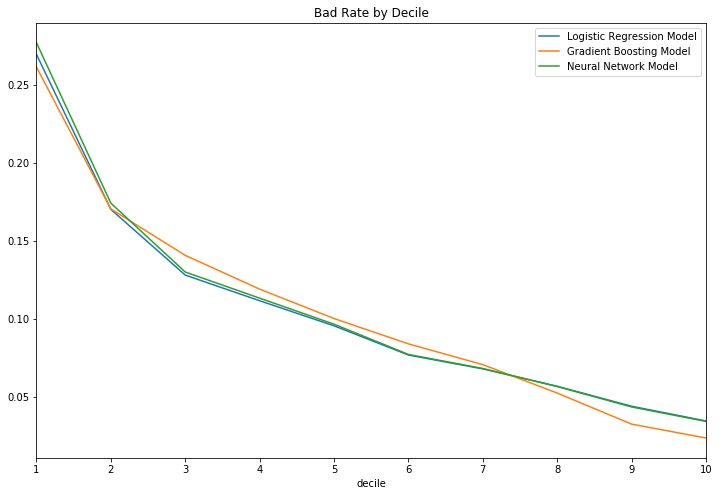

In [71]:
plt.rcParams["figure.figsize"] = (12, 8)
X_segmented.plot(title='Bad Rate by Decile', rot=0)

### Revise Interest Rates using Probability of Default

2. Assume risk free rate is 2%. Also assume that bad rate calculated in part 1, gives 1-year probability of default for each customer. Calculate the proper interest rate for each segment such that expected 1-year payoff for each segment equals 1-year risk-free pay off.

In [72]:
interest=X_segmented["Gradient Boosting Model"].apply(lambda x: 1.02/(1-x)-1)
print(interest)

decile
1     0.380680
2     0.229447
3     0.186870
4     0.157730
5     0.133509
6     0.113437
7     0.097484
8     0.076398
9     0.054289
10    0.044673
Name: Gradient Boosting Model, dtype: float64


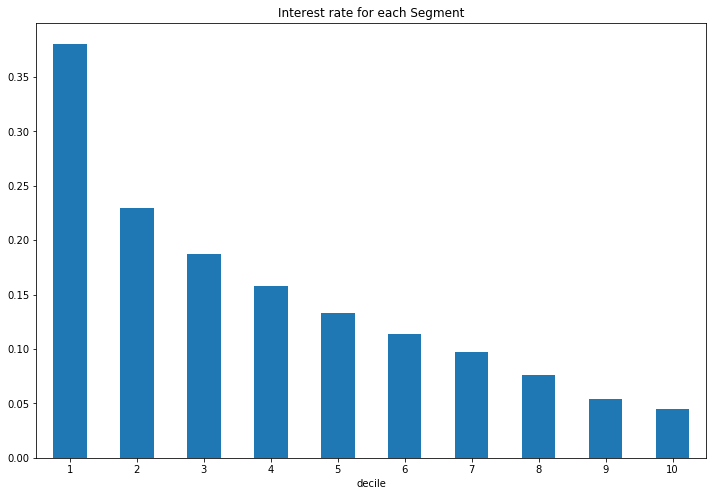

In [73]:
interest.plot(title="Interest rate for each Segment", rot=0, kind="bar")

### Calculate NPV of Loans

3. For the sake of simplicity assume that installments are paid annually; so for example a loan with 36 months term, will have 3 payments. Write a function that gets loan amount, number of payments, and interest rate as inputs, and calculates payments (look at this link for example: https://financeformulas.net/Loan_Payment_Formula.html). Use this function to calculate annual payment for each loan where interest rate comes from part 2. For the loan amount use "loan_amount" field and for the term use "term" field.

In [74]:
segmented_data=pd.DataFrame(segmentation(nn_pipeline))

segmented_data["loan amount"]=X["loan_amnt"]
segmented_data["term"]=X["term"]/12
segmented_data["interest"]=segmented_data["bad rate"].apply(lambda x: 1.02/(1-x)-1)
segmented_data["grade"]=X["grade"]
segmented_data["dti"]=X["dti"]

segmented_data.dropna(inplace=True)

In [75]:
# payments = (interest * loan amount)/(1 - (1 + interest^(-term)))
segmented_data["payments"]=(segmented_data["interest"]*segmented_data["loan amount"])/(1-(1+segmented_data["interest"])**(-segmented_data["term"]))

In [76]:
segmented_data

,bad rate,decile,loan amount,term,interest,grade,dti,payments
0,0.118096,4,2500.0,3.0,0.156589,2.0,18.24,1106.925324
1,0.178188,2,30000.0,5.0,0.241160,3.0,26.52,10953.786801
2,0.156098,2,5000.0,3.0,0.208671,3.0,10.51,2405.916772
3,0.137718,3,4000.0,3.0,0.182908,3.0,16.74,1848.270546
4,0.115186,4,30000.0,5.0,0.152785,2.0,26.35,9008.555848
...,...,...,...,...,...,...,...,...
998798,0.118253,4,6000.0,3.0,0.156794,1.0,15.93,2657.519786
998799,0.044756,9,8000.0,3.0,0.067790,1.0,18.20,3036.112442
998800,0.075045,6,11200.0,5.0,0.102757,5.0,26.13,2975.366552
998801,0.295331,1,6000.0,3.0,0.447488,1.0,9.33,4005.723811


4. Write a function that gets loan amount, probability of default, loan term, loan installment, and discount rate as inputs, and calculates the expected NPV of loan. Use this function to calculate expected NPV for each loan. For Probability of Default, use outputs of your scoring model. For loan installment use results of part 3. For discount rate use risk free rate.

Hint: Note that cash flows are stochastic. For example if probability of default for a customer is 10%, with 10% probability he/she will default at the end of the first year, hence zero payoff. With 90% bank will collect the first year installment, and will continue to second year. In the second year, again with 10% probability customer will default, and with 90% no default. Therefore probability that bank collects second year installment is 0.9*0.9 = 0.81. Continue until loan maturity.

In [77]:
def calculate_npv(row):
    rf_rate = 0.02
    disc_factor=(1-row["bad rate"])/(1+rf_rate)
    cashflows=[-row["loan amount"]]
    for i in range(1,int(row["term"])+1):
        cashflows.append(row["payments"]*(disc_factor**i))
        
    return np.sum(cashflows)
    
segmented_data["npv"]=segmented_data.apply(calculate_npv, axis=1)

In [78]:
segmented_data

,bad rate,decile,loan amount,term,interest,grade,dti,payments,npv
0,0.118096,4,2500.0,3.0,0.156589,2.0,18.24,1106.925324,-1.136868e-13
1,0.178188,2,30000.0,5.0,0.241160,3.0,26.52,10953.786801,-5.911716e-12
2,0.156098,2,5000.0,3.0,0.208671,3.0,10.51,2405.916772,2.273737e-13
3,0.137718,3,4000.0,3.0,0.182908,3.0,16.74,1848.270546,-6.821210e-13
4,0.115186,4,30000.0,5.0,0.152785,2.0,26.35,9008.555848,-1.000444e-11
...,...,...,...,...,...,...,...,...,...
998798,0.118253,4,6000.0,3.0,0.156794,1.0,15.93,2657.519786,-1.818989e-12
998799,0.044756,9,8000.0,3.0,0.067790,1.0,18.20,3036.112442,-9.094947e-13
998800,0.075045,6,11200.0,5.0,0.102757,5.0,26.13,2975.366552,1.591616e-12
998801,0.295331,1,6000.0,3.0,0.447488,1.0,9.33,4005.723811,4.547474e-13


5. Calculate total expected NPV for each segment. Plot total Expected NPV versus Bad Rate. What is your expectation about the shape of the curve?

In [79]:
segmented_data.groupby(['decile']).mean()

,bad rate,loan amount,term,interest,grade,dti,payments,npv
decile,,,,,,,,
1,0.276791,15302.792057,3.567921,0.430817,1.622124,19.291687,9240.294244,4.749768e-15
2,0.174032,15412.417667,3.571586,0.235176,1.584970,19.348391,6868.691081,-5.271353e-16
3,0.129924,15261.144017,3.560253,0.172412,1.608479,19.216883,6107.401096,-2.459797e-14
4,0.113190,15354.050018,3.568877,0.150209,1.598256,19.333414,5887.201516,5.379228e-15
5,0.096509,15315.396028,3.565477,0.129018,1.570629,19.297721,5646.512514,4.020803e-15
6,0.077142,15259.712520,3.554414,0.105277,1.572163,19.262957,5384.621978,2.524203e-14
7,0.068135,15337.996642,3.562975,0.094587,1.542357,19.239749,5282.384559,1.733505e-14
8,0.056585,15523.617266,3.569916,0.081206,1.520802,19.304179,5202.600780,7.571182e-14
9,0.043505,15551.675390,3.578415,0.066400,1.490906,19.338717,5041.989643,1.752869e-14


Text(0, 0.5, 'NPV')

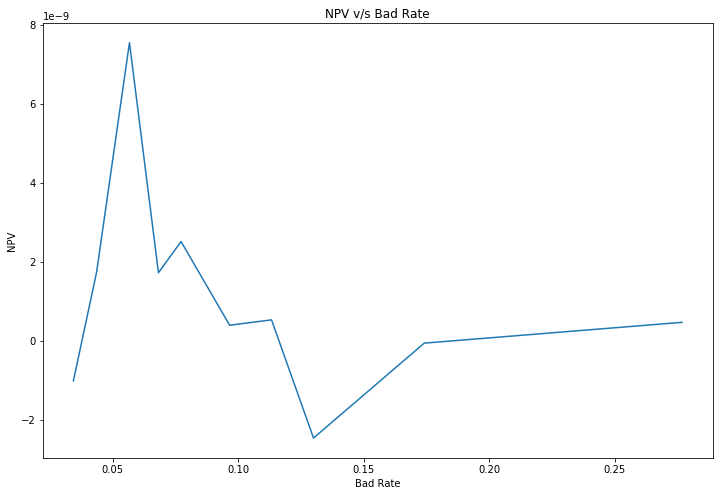

In [80]:
bad_rate = segmented_data.groupby(['decile'])['bad rate'].mean()
npv = segmented_data.groupby(['decile'])['npv'].sum()

plt.plot(bad_rate, npv)
plt.title('NPV v/s Bad Rate')
plt.xlabel('Bad Rate')
plt.ylabel('NPV')